## CIFAR-10 UAP - Attack Generation
We generate (via SGD), visualize, and evaluate the following UAPs:
1. Untargeted UAP
2. Targeted UAP

In [ ]:
!git clone https://github.com/kenny-co/sgd-uap-torch.git

Cloning into 'sgd-uap-torch'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 208 (delta 72), reused 173 (delta 38), pack-reused 0
Receiving objects: 100% (208/208), 6.08 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [ ]:
import os
os.chdir("/content/")
! git clone https://github.com/jacobgil/pytorch-grad-cam.git

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [ ]:
#os.chdir("..")
import os
os.chdir("sgd-uap-torch/")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append(os.path.realpath('..'))

from attacks import uap_sgd
from utils import loader_cifar, model_cifar, evaluate

dir_data = '/data/cifar10'
dir_uap = '../uaps/cifar10/'

trainloader = loader_cifar(dir_data = dir_data, train = True, batch_size=250)
testloader = loader_cifar(dir_data = dir_data, train = False, batch_size=250)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
!ls
# load model
model, best_acc = model_cifar('resnet18', ckpt_path = '/content/resnet18.pth')
print(best_acc)

attacks.py	    LICENSE.md	  __pycache__	    uaps
docs		    models_cifar  README.md	    utils.py
imgnet_labels.json  notebooks	  requirements.txt
94.02


sample image size:  torch.Size([3, 32, 32])
sample image true label:  tensor(6)
sample image predicted label:  tensor(0, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy: 0.9402


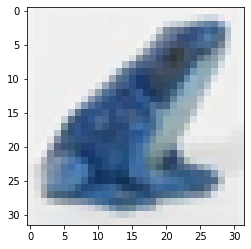

In [ ]:
# clean accuracy
_, _, _, _, outputs, labels = evaluate(model, testloader)
for i, (x_val, y_val) in enumerate(testloader):
  if i==7:
    print("sample image size: ", x_val[i].size())
    print("sample image true label: ", y_val[i])
    plt.imshow(np.transpose(x_val[i].numpy(), (1, 2, 0)))
    out = torch.nn.functional.softmax(model(x_val[i].cuda()))
    print("sample image predicted label: ", torch.argmax(out)) 

print('Accuracy:', sum(outputs == labels) / len(labels))

In [ ]:
## show the CAM of uncorrupted clean model
import os
os.chdir("/content/pytorch-grad-cam/")
#!pip install opencv-python
#!pip install -r requirements.txt
!ls

cam.py			      pyproject.toml	setup.cfg
examples		      pytorch_grad_cam	setup.py
gradcam_cam_clean_output.jpg  README.md		tests
LICENSE			      requirements.txt	usage_examples


In [ ]:
## show the CAM of uncorrupted clean model
!pip install ttach
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import     GradCAM, ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=True,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='/content/0003.jpg',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=['gradcam', 'gradcam++',
                                 'scorecam', 'xgradcam',
                                 'ablationcam', 'eigencam',
                                 'eigengradcam', 'layercam', 'fullgrad'],
                        help='Can be gradcam/gradcam++/scorecam/xgradcam'
                             '/ablationcam/eigencam/eigengradcam/layercam')

    parser.add_argument('--model', help='model instance')

    args, unknown = parser.parse_known_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args


if __name__ == '__main__':
    """ python cam.py -image-path <path_to_image>
    Example usage of loading an image, and computing:
        1. CAM
        2. Guided Back Propagation
        3. Combining both
    """

    args = get_args()
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

  

    #print(model)
    #models.resnet50(pretrained=True)

    # Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4[-1]
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
    target_layers = [model[1].module.layer4[-1]]

    rgb_img = cv2.imread(args.image_path)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255  # (32, 32, 3)
    input_tensor = torch.from_numpy(rgb_img)
    input_tensor = input_tensor.unsqueeze(0).permute(0, 3, 1, 2)
    # print(input_tensor.size())  # (1, 3, 32, 32)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    out = torch.nn.functional.softmax(model(input_tensor.cuda()))
    print("predicted label",torch.argmax(out, axis = 1)) 
    target_category = None

    # Using the with statement ensures the context is freed, and you can
    # recreate different CAM objects in a loop.
    cam_algorithm = methods[args.method]
    with cam_algorithm(model=model,
                       target_layers=target_layers,
                       use_cuda=args.use_cuda) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            target_category=target_category,
                            aug_smooth=args.aug_smooth,
                            eigen_smooth=args.eigen_smooth)

        # Here grayscale_cam has only one image in the batch
        #grayscale_cam = torch.FloatTensor(grayscale_cam)
        #print("GSC",grayscale_cam, grayscale_cam.size())
        grayscale_cam = grayscale_cam[0, :]
        #print("DDDD", grayscale_cam)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
        
    #gb_model = GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
    #gb = gb_model(input_tensor, target_category=target_category)

    #cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    #cam_gb = deprocess_image(cam_mask * gb)
    #gb = deprocess_image(gb)

    cv2.imwrite(f'{args.method}_cam_clean_output.jpg', cam_image)
    #cv2.imwrite(f'{args.method}_gb_clean_output.jpg', gb)
    #cv2.imwrite(f'{args.method}_cam_gb_clean_output.jpg', cam_gb)


Using GPU for acceleration
predicted label tensor([3], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



## 1. Untargeted UAP
Recommended to try several restarts and choose the best untargeted UAP

In [ ]:
from torch.autograd import Variable
from  torch.nn import Parameter

def normalize(LRP):
  LRP = LRP - LRP.min(dim=1)[0].min(dim=1)[0].min(dim=1)[0].reshape(-1,1,1,1)
  LRP_shape = LRP.shape
  LRP = LRP/(LRP.max(dim=1)[0].max(dim=1)[0].max(dim=1)[0].reshape(-1,1,1,1) + 1e-8)
  return LRP

def center_mass(LRP):
  n,c,h,w = LRP.shape
  LRP = normalize(LRP)
  LRP_sum = LRP.sum(dim=(2,3))

  h_vector = torch.range(1,h).reshape(1,1,h,1).cuda()
  w_vector = torch.range(1,h).reshape(1,1,1,w).cuda()

  LRP_h = (LRP.sum(dim=3, keepdim=True)*h_vector).sum(dim=2).squeeze() / (LRP_sum + 1e-8)
  LRP_w = (LRP.sum(dim=2, keepdim=True)*w_vector).sum(dim=3).squeeze() / (LRP_sum + 1e-8)

  distance = (LRP_h.abs() + LRP_w.abs())
  #distance.requires_grad = True
  return distance


In [ ]:
import math
import torch
import torch.nn as nn
import time

'''
Basic version of untargeted stochastic gradient descent UAP adapted from:
[AAAI 2020] Universal Adversarial Training
- https://ojs.aaai.org//index.php/AAAI/article/view/6017
Layer maximization attack from:
Universal Adversarial Perturbations to Understand Robustness of Texture vs. Shape-biased Training
- https://arxiv.org/abs/1911.10364
'''
def uap_sgd_exp(model, loader, nb_epoch, eps, target_layer ,beta = 12, step_decay = 0.8, y_target = None, loss_fn = None,uap_init = None):
    '''
    INPUT
    model       model
    loader      dataloader
    nb_epoch    number of optimization epochs
    eps         maximum perturbation value (L-infinity) norm
    beta        clamping value
    y_target    target class label for Targeted UAP variation
    loss_fn     custom loss function (default is CrossEntropyLoss)
    layer_name  target layer name for layer maximization attack
    uap_init    custom perturbation to start from (default is random vector with pixel values {-eps, eps})
    
    OUTPUT
    delta.data  adversarial perturbation
    losses      losses per iteration
    '''
    _, (x_val, y_val) = next(enumerate(loader))
    batch_size = len(x_val)
    if uap_init is None:
        #batch_delta = torch.zeros_like(x_val) # initialize as zero vector
        batch_delta = torch.normal(torch.zeros_like(x_val), torch.ones_like(x_val), generator=None, out=None)*eps
        batch_delta = torch.clamp(batch_delta, -eps, eps)
    else:
        batch_delta = uap_init.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    delta = batch_delta[0]
    losses = []
    layer_name =None

    # loss function
    loss_fn = nn.CrossEntropyLoss(reduction = 'none')
    beta = torch.cuda.FloatTensor([beta])
          
    def save_activation1(model, input, output):
        global activations
        activations = output      
    
    target_layer.register_forward_hook(save_activation1)

    def clamped_loss(output, target):
      loss = torch.mean(torch.min(loss_fn(output, target), beta))
      return loss

    # L2 norm loss between raw activation
    def conv_pairing_loss1(x1,x2):
      model(x1)
      a1 = activations
      model(x2)
      a2 = activations
      norm1 = torch.norm(a1-a2,2, (1,3))
      return torch.mean(norm1)

    # dice loss between raw activation
    def conv_pairing_loss2(x1,x2):
      model(x1)
      a1 = activations
      model(x2)
      a2 = activations
      norm1 = torch.norm(a1-a2,2, (1,3))
      intersection = torch.sum(a1*a2, (1,2,3))
      dice = (2*intersection) / torch.sum(a1, (1,2,3)) + torch.sum(a2, (1,2,3))
      return -torch.mean(dice)
    
    # center mass loss
    def conv_pairing_loss3(x1,x2):
      model(x1)
      a1 = activations
      model(x2)
      a2 = activations
      dis = center_mass(a1)-center_mass(a2)
      return torch.mean(torch.norm(dis,'fro'))

    # L2 norm loss between heatmap (weighted activation)
    def conv_pairing_loss4(x1,x2):
      for p in model.parameters():
        p.requires_grad = True
      cam1 = GradCAM(model=model, target_layers=[target_layer], use_cuda= True)
      grayscale_cam1 = cam1(input_tensor=x1, target_category=None)[0, :]
      heatmap1 = cv2.applyColorMap(np.uint8(255 * grayscale_cam1), cv2.COLORMAP_JET)
      heatmap1 = cv2.cvtColor(heatmap1, cv2.COLOR_BGR2RGB)
      heatmap1 = np.swapaxes(heatmap1,0,2)
      heatmap1 = (np.swapaxes(heatmap1,1,2))
      heatmap1 = np.float32(heatmap1) / 255
      heatmap1 = heatmap1 / np.max(heatmap1)
      heatmap1 = np.uint8(255 * heatmap1)

      cam2 = GradCAM(model=model, target_layers=[target_layer], use_cuda= True)
      grayscale_cam2 = cam2(input_tensor=x2, target_category=None)[0, :]
      for p in model.parameters():
        p.requires_grad = False
      heatmap2 = cv2.applyColorMap(np.uint8(255 * grayscale_cam2), cv2.COLORMAP_JET)
      heatmap2 = cv2.cvtColor(heatmap2, cv2.COLOR_BGR2RGB)
      heatmap2 = np.swapaxes(heatmap2,0,2)
      heatmap2 = (np.swapaxes(heatmap2,1,2))
      heatmap2 = np.float32(heatmap2) / 255
      heatmap2 = heatmap2 / np.max(heatmap2)
      heatmap2 = np.uint8(255 * heatmap2)     

      target_att = (heatmap1 > 150).astype(int)
      base_att = (heatmap2 > 150).astype(int)

      return torch.norm(torch.from_numpy((target_att-base_att)*1.0), 'fro')

    # dice loss between heatmap (weighted activation)
    def conv_pairing_loss5(x1,x2):
      for p in model.parameters():
        p.requires_grad = True
      cam1 = GradCAM(model=model, target_layers=[target_layer], use_cuda= True)
      grayscale_cam1 = cam1(input_tensor=x1, target_category=None)[0, :]
      heatmap1 = cv2.applyColorMap(np.uint8(255 * grayscale_cam1), cv2.COLORMAP_JET)
      heatmap1 = cv2.cvtColor(heatmap1, cv2.COLOR_BGR2RGB)
      heatmap1 = np.swapaxes(heatmap1,0,2)
      heatmap1 = (np.swapaxes(heatmap1,1,2))
      heatmap1 = np.float32(heatmap1) / 255
      heatmap1 = heatmap1 / np.max(heatmap1)
      heatmap1 = np.uint8(255 * heatmap1)

      cam2 = GradCAM(model=model, target_layers=[target_layer], use_cuda= True)
      grayscale_cam2 = cam2(input_tensor=x2, target_category=None)[0, :]
      for p in model.parameters():
        p.requires_grad = False
      heatmap2 = cv2.applyColorMap(np.uint8(255 * grayscale_cam2), cv2.COLORMAP_JET)
      heatmap2 = cv2.cvtColor(heatmap2, cv2.COLOR_BGR2RGB)
      heatmap2 = np.swapaxes(heatmap2,0,2)
      heatmap2 = (np.swapaxes(heatmap2,1,2))
      heatmap2 = np.float32(heatmap2) / 255
      heatmap2 = heatmap2 / np.max(heatmap2)
      heatmap2 = np.uint8(255 * heatmap2)     

      target_att = (heatmap1 > 150).astype(int)
      base_att = (heatmap2 > 150).astype(int)

      # IoU calculation..
      # binary class (one-hot vector) version
      axes = (1, 2)
      intersection = np.sum(np.abs(target_att * base_att), axis=axes)
      mask_sum = np.sum(np.abs(base_att), axis=axes) + np.sum(np.abs(target_att), axis=axes)
      union = mask_sum - intersection
      smooth = 0.000001
      iou_score = (intersection + smooth) / (union + smooth)
      dice_score = 2 * (intersection + smooth) / (mask_sum + smooth)
      return -torch.sum(torch.from_numpy(dice_score*1.0), 0)
                
    batch_delta.requires_grad_()
    for epoch in range(nb_epoch):
        print('epoch %i/%i' % (epoch + 1, nb_epoch))
        
        # perturbation step size with decay
        eps_step = eps * step_decay
        
        for i, (x_val, y_val) in enumerate(loader):
            #batch_delta.grad.data.zero_()
            batch_delta.data = delta.unsqueeze(0).repeat([x_val.shape[0], 1, 1, 1])
            # for targeted UAP, switch output labels to y_target
            if y_target is not None: y_val = torch.ones(size = y_val.shape, dtype = y_val.dtype) * y_target
            
            perturbed = torch.clamp((x_val + batch_delta).cuda(), 0, 1)
            outputs = model(perturbed)
            
            # loss function value
            loss = -clamped_loss(outputs, y_val.cuda())
            """
            if layer_name is None: loss = clamped_loss(outputs, y_val.cuda())
            else: loss = main_value
            """
            #conv_pairing_loss1(x_val.cuda(), perturbed).requires_grad = True;
            loss += conv_pairing_loss3(x_val.cuda(), perturbed)
            #if y_target is not None: loss = -loss # minimize loss for targeted UAP
            print(loss) # -clamped_loss(outputs, y_val.cuda()),  conv_pairing_loss5(x_val.cuda(), perturbed))
            #loss.requires_grad = True
            losses.append(loss)
            loss.backward()
            # batch update
            grad_sign = batch_delta.grad.data.mean(dim = 0).sign()
            delta = delta + grad_sign * eps_step
            delta = torch.clamp(delta, -eps, eps)
            
            batch_delta.grad.data.zero_()
            if i == 20:
              break
    if layer_name is not None: handle.remove() # release hook
    
    return delta.data, losses

In [ ]:
nb_epoch = 5
eps = 9 / 255
beta = 10
target_layer = model[1].module.layer4[-1]
for p in model.parameters():
  p.requires_grad = False
uap, losses = uap_sgd_exp(model, trainloader, nb_epoch, eps, target_layer, beta)

epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  app.launch_new_instance()


tensor(670.6844, device='cuda:0', grad_fn=<AddBackward0>)
tensor(792.8210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(786.9615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(792.3157, device='cuda:0', grad_fn=<AddBackward0>)
tensor(800.9692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(827.6982, device='cuda:0', grad_fn=<AddBackward0>)
tensor(800.3941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(774.0421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(835.6586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(821.8336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(850.5096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(833.5959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(860.9705, device='cuda:0', grad_fn=<AddBackward0>)
tensor(854.0711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(870.7838, device='cuda:0', grad_fn=<AddBackward0>)
tensor(855.2073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(808.3166, device='cuda:0', grad_fn=<AddBackward0>)
tensor(816.339

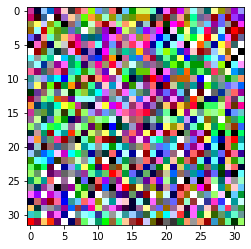

In [ ]:
# visualize UAP
from PIL import Image 
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

for p in model.parameters():
  p.requires_grad = True

rawim = Image.open("/content/0003.jpg")
image = ToTensor()(rawim).unsqueeze(0) # unsqueeze to add artificial first dimension
pert = torch.clamp((image + uap).cuda(), 0, 1) # clamp to [0, 1]
save_image(pert, "/content/0003_pert.jpg")

plt.imshow(np.transpose(((uap / eps) + 1) / 2, (1, 2, 0)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


178
Total loss: [0.58503975 0.57761934 0.57635449]


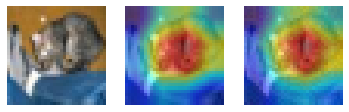

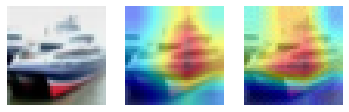

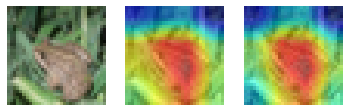

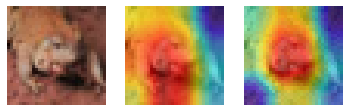

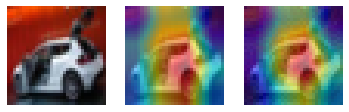

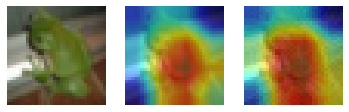

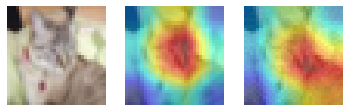

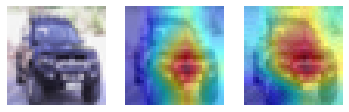

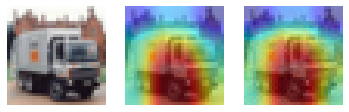

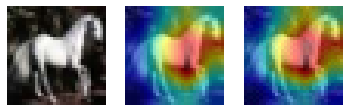

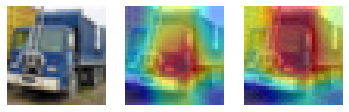

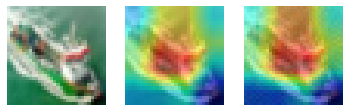

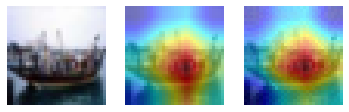

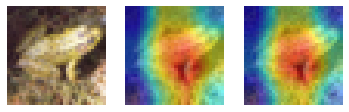

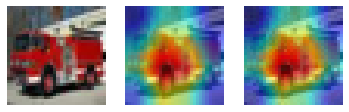

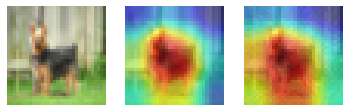

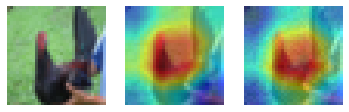

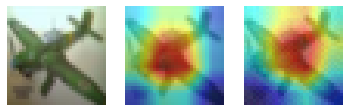

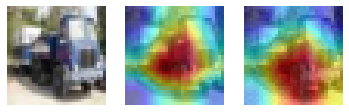

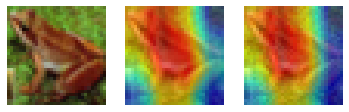

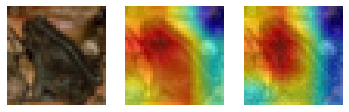

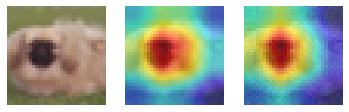

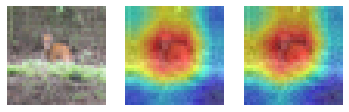

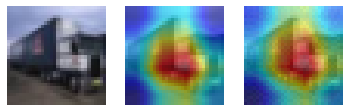

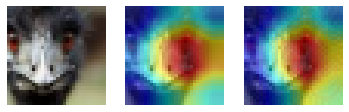

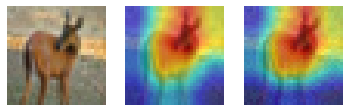

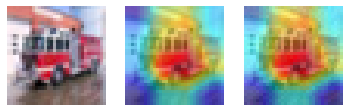

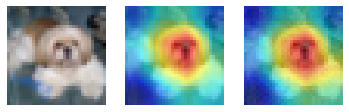

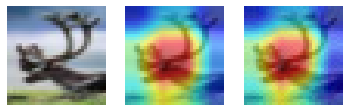

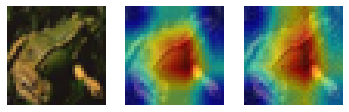

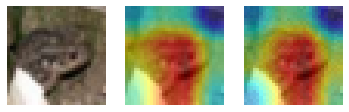

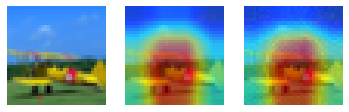

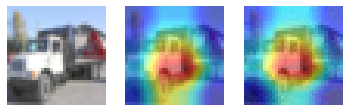

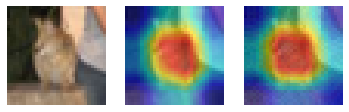

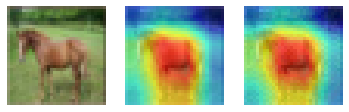

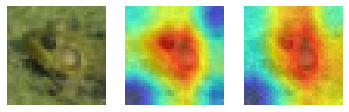

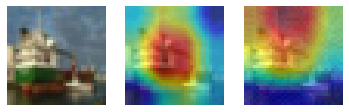

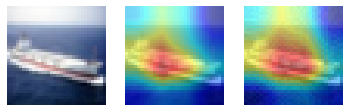

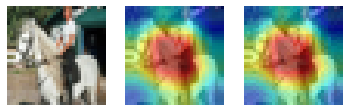

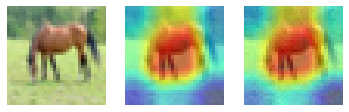

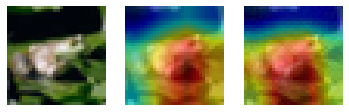

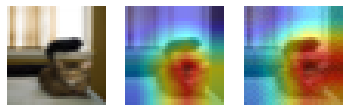

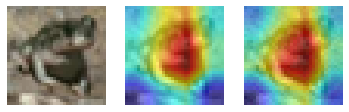

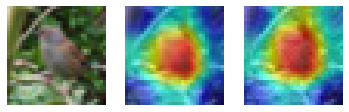

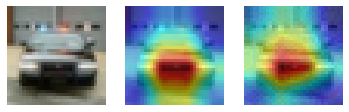

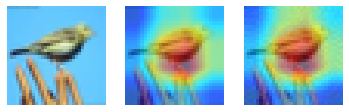

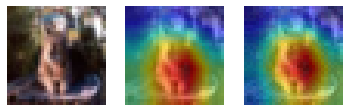

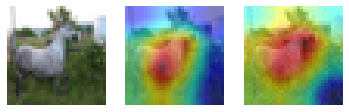

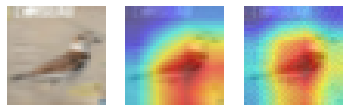

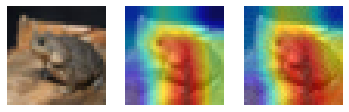

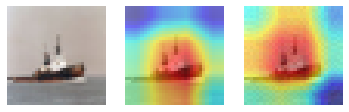

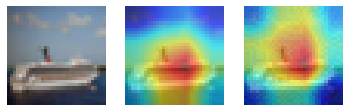

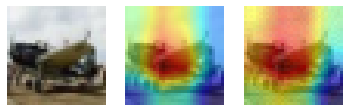

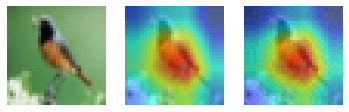

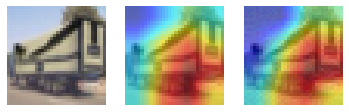

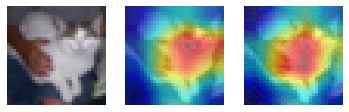

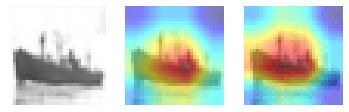

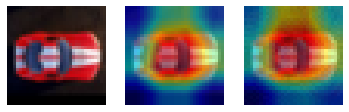

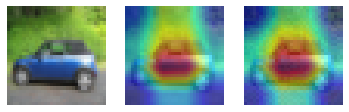

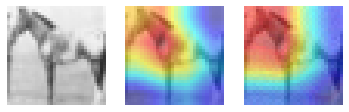

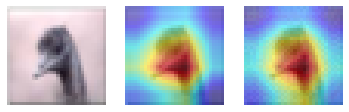

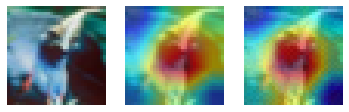

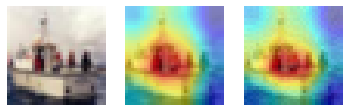

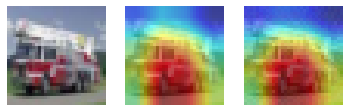

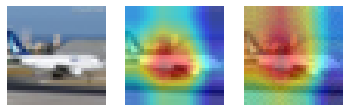

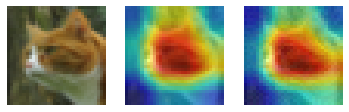

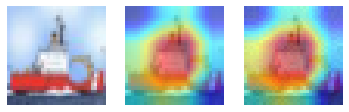

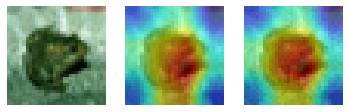

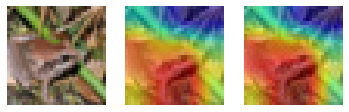

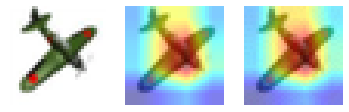

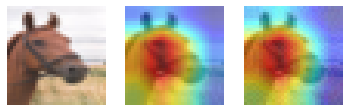

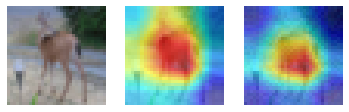

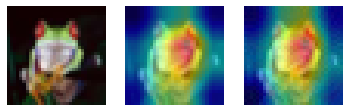

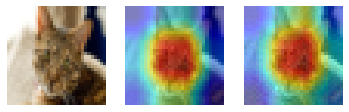

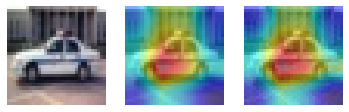

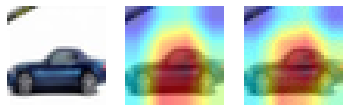

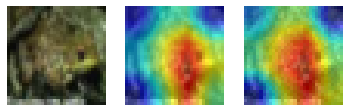

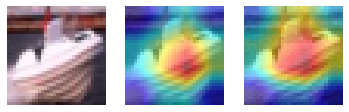

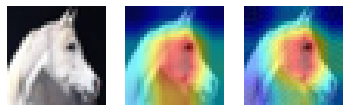

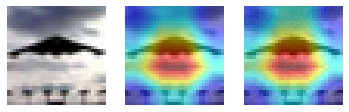

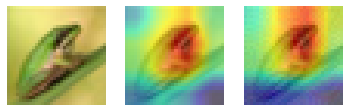

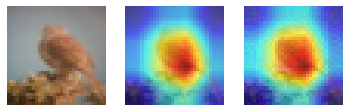

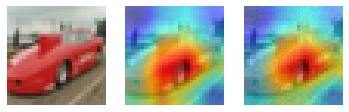

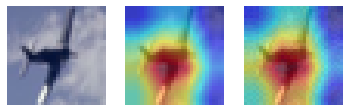

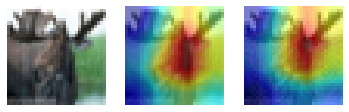

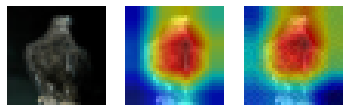

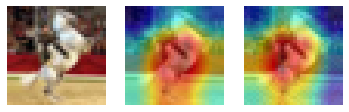

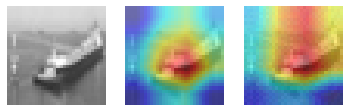

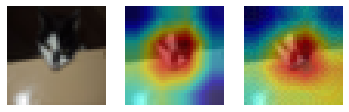

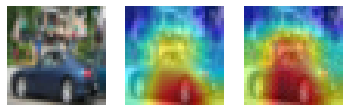

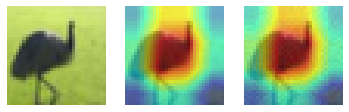

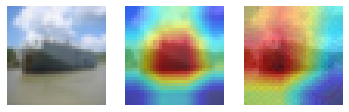

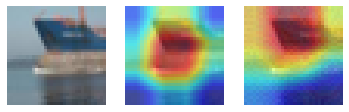

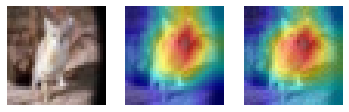

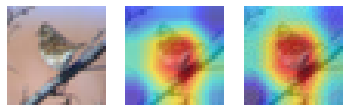

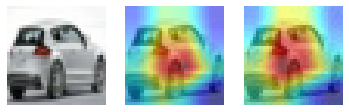

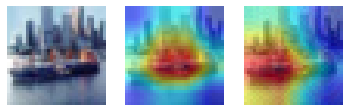

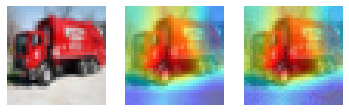

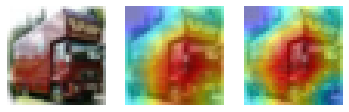

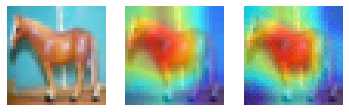

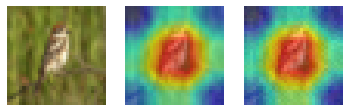

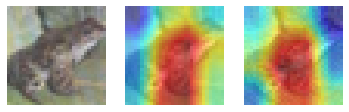

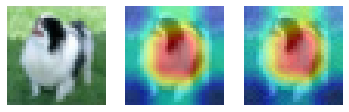

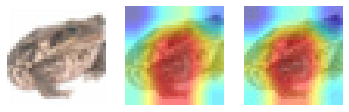

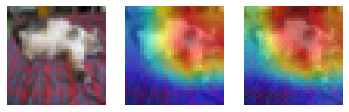

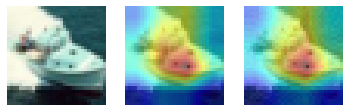

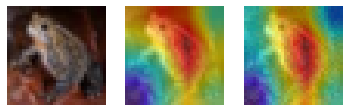

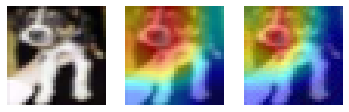

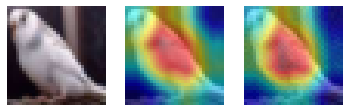

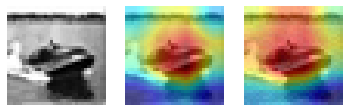

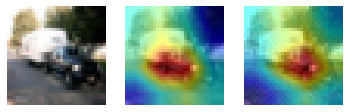

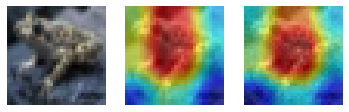

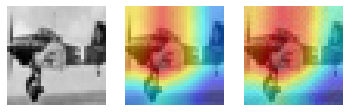

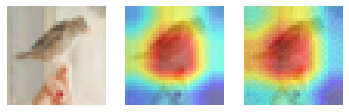

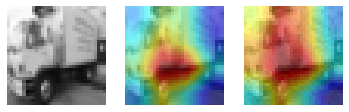

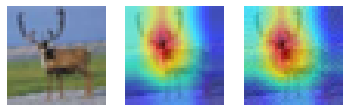

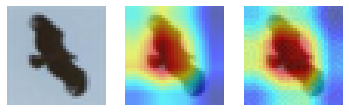

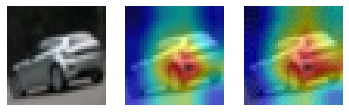

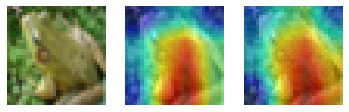

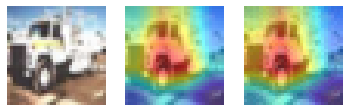

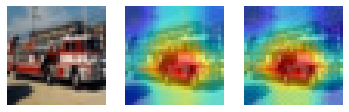

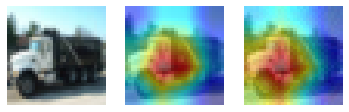

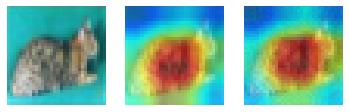

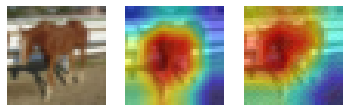

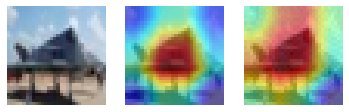

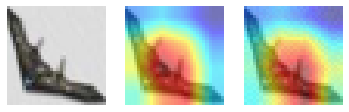

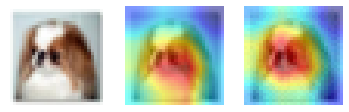

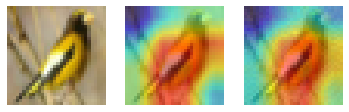

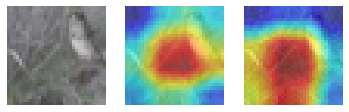

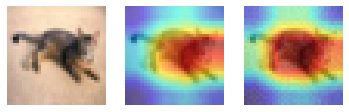

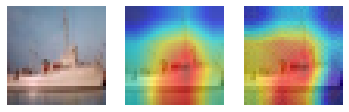

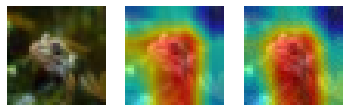

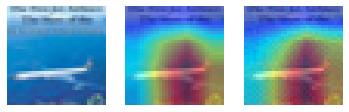

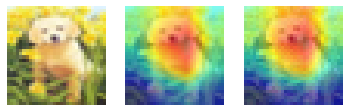

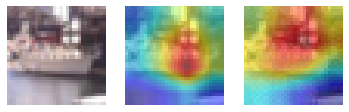

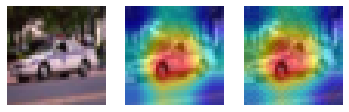

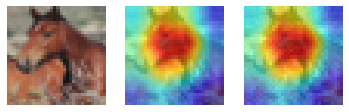

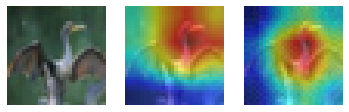

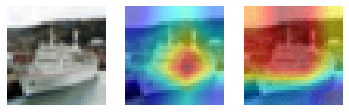

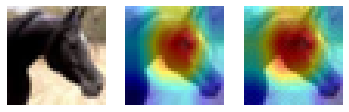

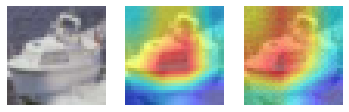

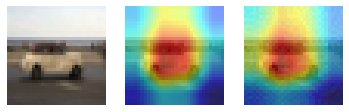

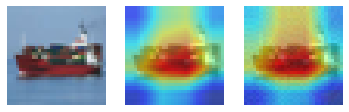

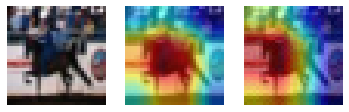

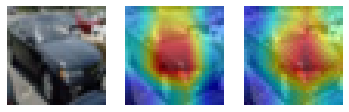

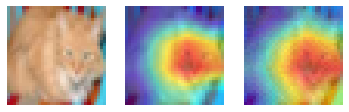

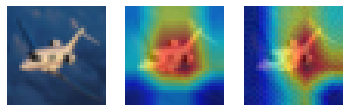

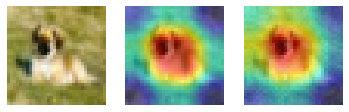

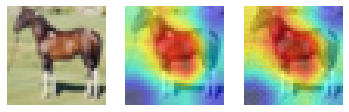

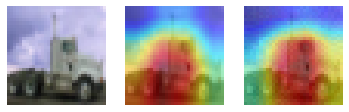

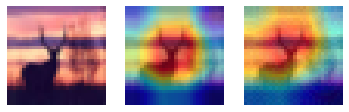

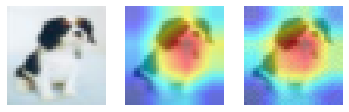

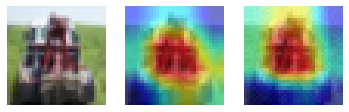

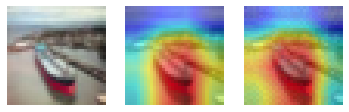

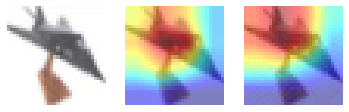

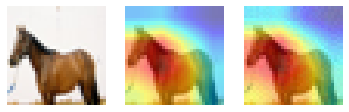

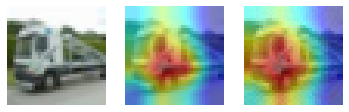

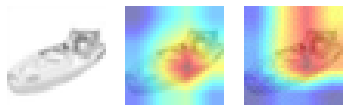

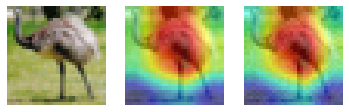

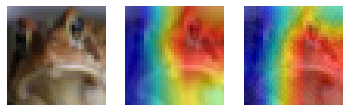

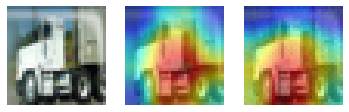

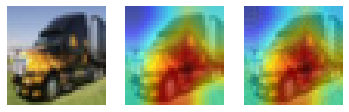

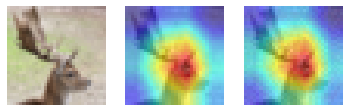

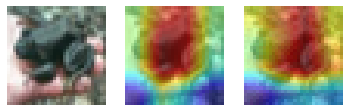

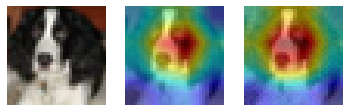

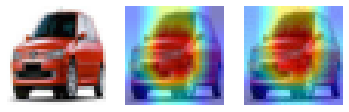

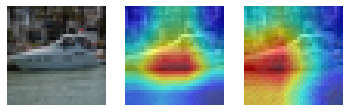

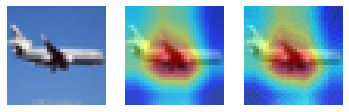

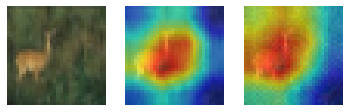

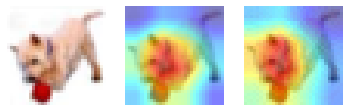

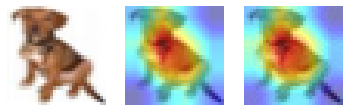

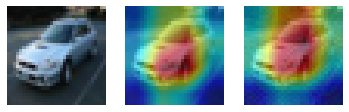

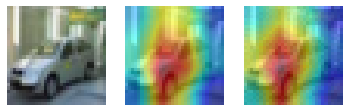

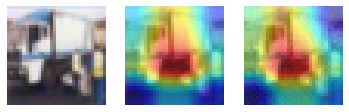

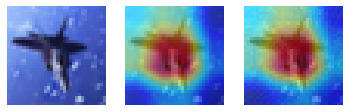

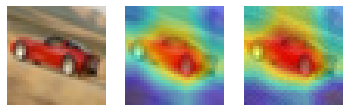

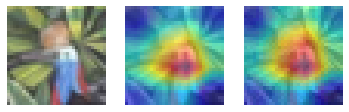

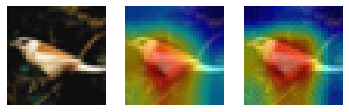

In [ ]:
!pip install ttach
from pytorch_grad_cam import GradCAM
from google.colab.patches import cv2_imshow


def batch_evaluate(loader, uap, model):
  batch, gt_labels = next(iter(loader))
  
  i = 0
  batch_size = batch.shape[0]
  total_loss = 0
  cam1 = GradCAM(model=model, target_layers=[target_layer], use_cuda= True)
  count=0
  
  for index in range(batch_size):
    x_clean = batch[index]
    gt_label = gt_labels[index]
    x_pert = torch.clamp((x_clean + uap).cpu(), 0, 1)

    grayscale_cam1 = cam1(input_tensor=x_clean, target_category=None)[0, :]
    heatmap1 = cv2.applyColorMap(np.uint8(255 * grayscale_cam1), cv2.COLORMAP_JET)
    heatmap1 = cv2.cvtColor(heatmap1, cv2.COLOR_BGR2RGB)
    heatmap1 = np.swapaxes(heatmap1,0,2)
    heatmap1 = (np.swapaxes(heatmap1,1,2))
    heatmap1 = np.float32(heatmap1) / 255
    heatmap1 = heatmap1 / np.max(heatmap1)
    heatmap1 = np.uint8(255 * heatmap1)

    grayscale_cam2 = cam1(input_tensor=x_pert, target_category=None)[0, :]
    heatmap2 = cv2.applyColorMap(np.uint8(255 * grayscale_cam2), cv2.COLORMAP_JET)
    heatmap2 = cv2.cvtColor(heatmap2, cv2.COLOR_BGR2RGB)
    heatmap2 = np.swapaxes(heatmap2,0,2)
    heatmap2 = (np.swapaxes(heatmap2,1,2))
    heatmap2 = np.float32(heatmap2) / 255
    heatmap2 = heatmap2 / np.max(heatmap2)
    heatmap2 = np.uint8(255 * heatmap2)     

    target_att = (heatmap1 > 150).astype(int)
    base_att = (heatmap2 > 150).astype(int)

    # IoU calculation..
    # binary class (one-hot vector) version
    axes = (1, 2)
    intersection = np.sum(np.abs(target_att * base_att), axis=axes)
    mask_sum = np.sum(np.abs(base_att), axis=axes) + np.sum(np.abs(target_att), axis=axes)
    union = mask_sum - intersection
    smooth = 0.000001
    iou_score = (intersection + smooth) / (union + smooth)
    dice_score = 2 * (intersection + smooth) / (mask_sum + smooth)

    out1 = torch.nn.functional.softmax(model(x_clean.cuda()))
    label1 = torch.argmax(out1, axis = 1).data.cpu().numpy()

    out2 = torch.nn.functional.softmax(model(x_pert.cuda()))
    label2 = torch.argmax(out2, axis = 1).data.cpu().numpy()

    
    if gt_label.numpy() == label1[0] and label1[0]==label2[0]:
      total_loss += dice_score
      count = count+1
      x_clean_n = x_clean.numpy()
      x_clean_n = np.moveaxis(x_clean_n, 0,-1)
      cam_image_clean = show_cam_on_image(x_clean_n, grayscale_cam1, use_rgb=True)
      x_pert_n = x_pert.numpy()
      x_pert_n = np.moveaxis(x_pert_n, 0,-1)
      cam_image_pert = show_cam_on_image(x_pert_n, grayscale_cam2, use_rgb=True)


      f, axarr = plt.subplots(1,3)
      axarr[0].axis('off')
      axarr[1].axis('off')
      axarr[2].axis('off')
      axarr[0].imshow(x_clean_n)
      axarr[1].imshow(cam_image_clean)
      axarr[2].imshow(cam_image_pert)   
      f.show()
      #heatmap = portable_explanation(model, [target_layer], x_pert)
      #cv2_imshow(heatmap)
    i += 1
  print(count)
  return total_loss/batch_size

  
for p in model.parameters():
  p.requires_grad = True

test_loss = batch_evaluate(testloader, uap, model)
print("Total loss: " + str(test_loss))

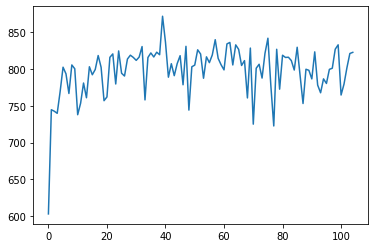

In [ ]:
# plot loss
plt.plot(losses)

In [ ]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, testloader, uap = uap)
print('Accuracy:', sum(outputs == labels) / len(labels))

Accuracy: 0.7311


(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

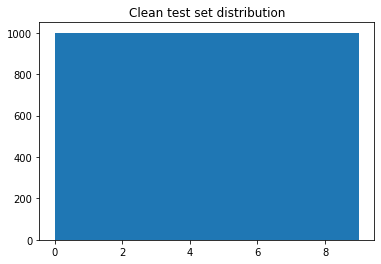

In [ ]:
# plot histogram
plt.title('Clean test set distribution')
plt.hist(labels)

(array([ 638.,  935., 1975., 1239.,  752.,  543., 1449.,  645.,  969.,
         855.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

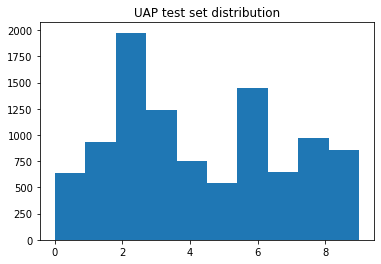

In [ ]:
# plot histogram
plt.title('UAP test set distribution')
plt.hist(outputs)